<a href="https://colab.research.google.com/github/VasanthPrakasam/Case-Study-1_E-commerce-Product-Recommendation-System/blob/main/E_commerce_Product_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
#load dataset
data = pd.read_csv('ecommerce_data.csv')
data.head()

,is_mobile,n_products_viewed,visit_duration,is_returning_visitor,time_of_day,user_action
0,1,0,0.657510,0,3,0
1,1,1,0.568571,0,2,1
2,1,0,0.042246,1,1,0
3,1,1,1.659793,1,1,2
4,0,1,2.014745,1,1,2


In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   is_mobile             500 non-null    int64  
 1   n_products_viewed     500 non-null    int64  
 2   visit_duration        500 non-null    float64
 3   is_returning_visitor  500 non-null    int64  
 4   time_of_day           500 non-null    int64  
 5   user_action           500 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 23.6 KB
None


In [ ]:
data.isnull().sum()

is_mobile               0
n_products_viewed       0
visit_duration          0
is_returning_visitor    0
time_of_day             0
user_action             0
dtype: int64

In [ ]:
scaler = StandardScaler()
data[['n_products_viewed','visit_duration']] = scaler.fit_transform(data[['n_products_viewed','visit_duration']])

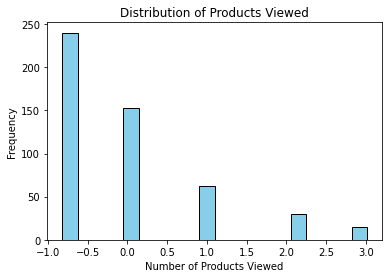

In [ ]:
plt.hist(data['n_products_viewed'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Products Viewed')
plt.xlabel('Number of Products Viewed')
plt.ylabel('Frequency')
plt.show()

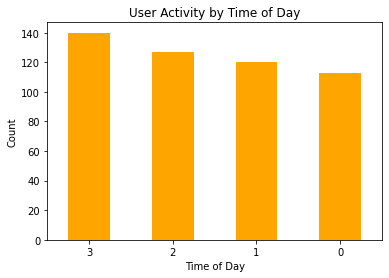

In [ ]:
data['time_of_day'].value_counts().plot(kind='bar', color='orange')
plt.title('User Activity by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

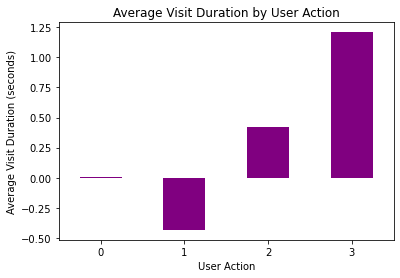

In [ ]:
avg_duration_by_action = data.groupby('user_action')['visit_duration'].mean()
avg_duration_by_action.plot(kind='bar', color='purple')
plt.title('Average Visit Duration by User Action')
plt.xlabel('User Action')
plt.ylabel('Average Visit Duration (seconds)')
plt.xticks(rotation=0)
plt.show()

In [ ]:
features = data[['n_products_viewed','visit_duration','is_returning_visitor', 'time_of_day']]

In [ ]:
#define target variable
target = data['user_action']

#split data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size= 0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train,y_train)

RandomForestClassifier()

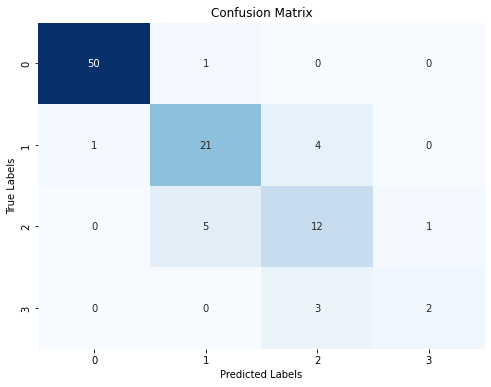

In [ ]:
plt.figure(figsize=(8, 6))
predictions = model.predict(X_test)
conf_matrix = confusion_matrix(y_test,predictions)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Accuracy: 0.85
Precision: 0.85
Recall: 0.85


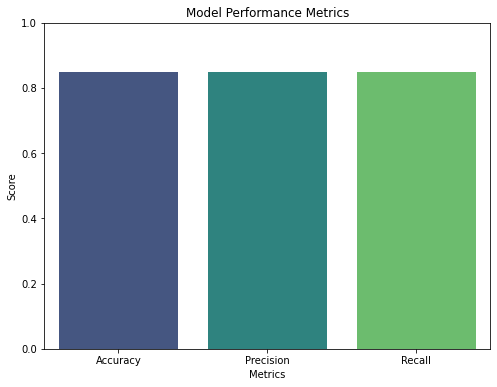

In [ ]:
# Generate predictions
predictions = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')

# Print metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

# Plot metrics
metrics = ['Accuracy', 'Precision', 'Recall']
values = [accuracy, precision, recall]

plt.figure(figsize=(8, 6))
sns.barplot(x=metrics, y=values, palette='viridis')
plt.ylim(0, 1)
plt.title('Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.show()

In [ ]:
user_item_matrix = data.pivot_table(
    index='time_of_day',
    columns='is_mobile',
    values='n_products_viewed'
)

# Fill missing values with 0s (no interaction if NaN)
user_item_matrix.fillna(0, inplace=True)
user_item_matrix.head()

is_mobile,0,1
time_of_day,,
0,-0.022016,0.230780
1,-0.121234,-0.036941
2,-0.099492,0.111114
3,0.031879,-0.040567


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the cosine similarity between time_of_day sessions (acting as user sessions)
user_similarity = cosine_similarity(user_item_matrix)

# Convert to DataFrame for easier interpretation, with time_of_day as both row and column indexes
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# Display the similarity matrix
user_similarity_df.head()

time_of_day,0,1,2,3
time_of_day,,,,
0,1.000000,-0.199319,0.804979,-0.841398
1,-0.199319,1.000000,0.420951,-0.361866
2,0.804979,0.420951,1.000000,-0.997938
3,-0.841398,-0.361866,-0.997938,1.000000


In [ ]:
def recommend(time_of_day, num_recommendations):
    # Sort similarity scores for the specified time_of_day in descending order, excluding itself
    similar_sessions = user_similarity_df[time_of_day].sort_values(ascending=False).index[1:num_recommendations+1]

    # Get products viewed during similar sessions and recommend those with the highest average views
    recommended_products = (
        data[data['time_of_day'].isin(similar_sessions)]
        .groupby('is_mobile')['n_products_viewed']
        .mean()
        .sort_values(ascending=False)
        .head(num_recommendations)
    )

    return recommended_products.index.tolist()

# Example recommendation
recommend(time_of_day=1, num_recommendations=5)
recommend(time_of_day=3, num_recommendations=2)

[1, 0]